Trading Strategy Testing Code

In [111]:
clear all

Import Libraries

In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Create Assessment Parameters

In [113]:
def calculate_sortino_ratio(daily_returns, risk_free_rate=0.01):
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = np.std(negative_returns, ddof=1)
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sortino_ratio = np.mean(excess_daily_returns) / downside_deviation
    return sortino_ratio * np.sqrt(252)  # annualised

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns, ddof=1)
    return sharpe_ratio * np.sqrt(252)  # annualised

def calculate_maximum_drawdown(cumulative_returns):
    cumulative_returns = np.array(cumulative_returns) + 1
    if len(cumulative_returns) > 0:
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdowns = (running_max - cumulative_returns) / running_max
        max_drawdown = np.max(drawdowns)
        return max_drawdown
    else:
        return 0

def calculate_calmar_ratio(annual_return, max_drawdown):
    # if max_drawdown is negative, make it positive for the ratio
    return annual_return / abs(max_drawdown)

1. Backtesting trading strategy after optimisation

Load Jan-May Data

In [114]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')
# Jan to May (Train)
data = data_read[data_read['DateTime_Minute'] <= '2025-05-31'].copy()
# June (Test)
#data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()

Run Train Simulation

In [115]:
def run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation
    buy_signals = 0
    sell_signals = 0

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.005
    exchange_fee_per_share = 0.003
    shares_per_transaction = 500

    look_ahead_window = 5 
    look_back_window = 20
  
    for i in range(look_back_window, len(data) - look_ahead_window):
        # Mid_price
        current_mid_price = data.iloc[i]['Mid-Price']
        future_prices = data.iloc[i+1:i+look_ahead_window+1]['Mid-Price']
        future_avg_price = future_prices.mean()

        # Bid_ask_spread      
        bid_ask_spread_threshold = data.iloc[i-look_back_window:i]['Bid_Ask_Spread'].quantile(quantile_optimised)
        future_bid_ask = data.iloc[i+1:i+look_ahead_window+1]['Bid_Ask_Spread']
        future_bid_ask_avg = future_bid_ask.mean()
        is_liquid = future_bid_ask_avg <= bid_ask_spread_threshold

        if future_avg_price > current_mid_price * future_buy_increase and is_liquid and cash > 0:
            # Buy condition
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            volume_ratio = (shares_to_buy) / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
            buy_signals += 1

        elif future_avg_price < current_mid_price * future_sell_decrease and is_liquid and shares_owned > 0:
            # Sell condition
            shares_to_sell = min(shares_per_transaction, shares_owned)
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0
            sell_signals += 1

        # Hold condition
        else: 
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Performance Metrics
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna() # daily returns from portfolio values
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data)) - 1
    else:
        # cases where annual return cannot be computed
        annual_return = None
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return initial_cash, final_valuation, final_valuation - initial_cash, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns

# optimised parameters
future_buy_increase = 1.01
future_sell_decrease = 0.97
quantile_optimised = 0.85

# Run simulation
results = []
initial_cash, final_valuation, profit_loss, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns = run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised)

# Make trading signal 'Hold' as default
data['Trading Signal'] = 'Hold'
# update the DataFrame with transactions for training of RF
for transaction in transactions:
    signal_type, shares, price, cost, cash, day_index = transaction
    data.at[day_index, 'Trading Signal'] = signal_type

# Append results to a list
results.append((future_buy_increase, future_sell_decrease, quantile_optimised, profit_loss, len(transactions), buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio))

# Output results
results_df = pd.DataFrame(results, columns=['Future Buy Increase', 'Future Sell Decrease', 'Bid Ask Spread Threshold', 'Profit/Loss', 'Number of Transactions', 'Number of Buy Signals', 'Number of Sell Signals', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
results_df.to_csv('Jan-May Trading Simulation Results.csv')

# Output data with signals
data.to_csv('Jan-May Data with Trading Signals.csv') 

results_df.head(50)


,Future Buy Increase,Future Sell Decrease,Bid Ask Spread Threshold,Profit/Loss,Number of Transactions,Number of Buy Signals,Number of Sell Signals,Sortino Ratio,Sharpe Ratio,Max Drawdown,Calmar Ratio
0,1.01,0.97,0.85,65981.652105,52492,15069,5754,0.365359,0.300327,0.685624,0.020702


Plot Training Data Figure

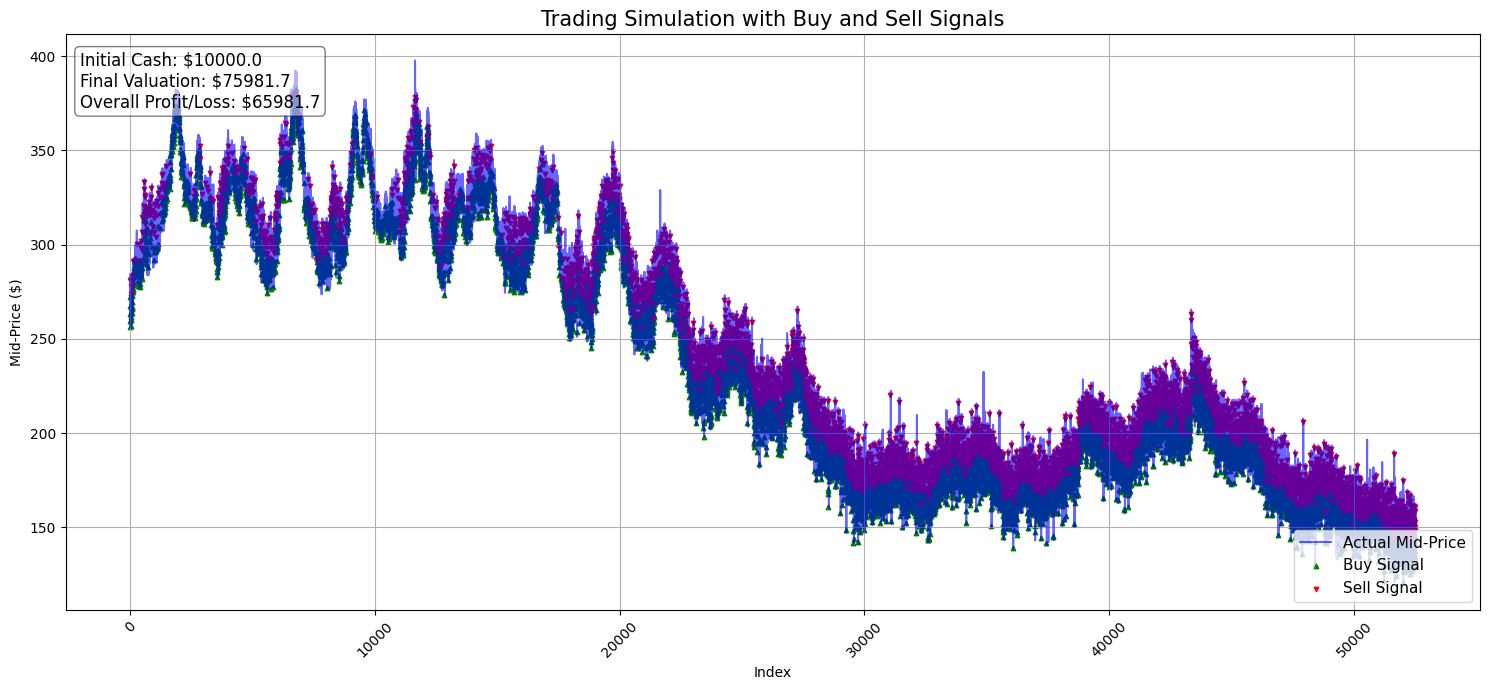

In [116]:
# Convert transactions to a DataFrame
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data.index, data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)


# Add buy and sell signals on index points
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals.index, buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1.0)
ax.scatter(sell_signals.index, sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1.0)

# Add labels with model results
final_valuation = final_valuation  # final calculation from the simulation
initial_cash = initial_cash  # from outputs
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Index')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Export Training Figure

In [117]:
fig.savefig('Trading Simulation Jan-May.png', dpi=600, bbox_inches='tight')

KeyboardInterrupt: 

2. Test Results using Optimised Parameters

Load June Data

In [123]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')
# Jan to May (Train)
#data = data_read[data_read['DateTime_Minute'] <= '2025-05-31'].copy()
# June (Test)
data_test = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()


Run June (Test) Trading Simulation

In [124]:
def run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation
    buy_signals = 0
    sell_signals = 0

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data_test['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.005
    exchange_fee_per_share = 0.003
    shares_per_transaction = 500

    look_ahead_window = 5 
    look_back_window = 20
  
    for i in range(look_back_window, len(data_test) - look_ahead_window):
        # Mid_price
        current_mid_price = data_test.iloc[i]['Mid-Price']
        future_prices = data_test.iloc[i+1:i+look_ahead_window+1]['Mid-Price']
        future_avg_price = future_prices.mean()

        # Bid_ask_spread      
        bid_ask_spread_threshold = data_test.iloc[i-look_back_window:i]['Bid_Ask_Spread'].quantile(quantile_optimised)
        future_bid_ask = data_test.iloc[i+1:i+look_ahead_window+1]['Bid_Ask_Spread']
        future_bid_ask_avg = future_bid_ask.mean()
        is_liquid = future_bid_ask_avg <= bid_ask_spread_threshold

        if future_avg_price > current_mid_price * future_buy_increase and is_liquid and cash > 0:
            # Buy condition
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            volume_ratio = (shares_to_buy) / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
            buy_signals += 1

        elif future_avg_price < current_mid_price * future_sell_decrease and is_liquid and shares_owned > 0:
            # Sell condition
            shares_to_sell = min(shares_per_transaction, shares_owned)
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0
            sell_signals += 1

        # Hold condition
        else: 
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Performance Metrics
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna() # daily returns from portfolio values
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data_test) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data_test)) - 1
    else:
        # cases where annual return cannot be computed
        annual_return = None
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data_test.iloc[-1]['Mid-Price']
    return initial_cash, final_valuation, final_valuation - initial_cash, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns

# optimised parameters
future_buy_increase = 1.01
future_sell_decrease = 0.97
quantile_optimised = 0.85

# Run simulation
results = []
initial_cash_test, final_valuation_test, profit_loss_test, transactions_test, buy_signals_test, sell_signals_test, sortino_ratio_test, sharpe_ratio_test, max_drawdown_test, calmar_ratio_test, daily_returns_test = run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised)

# Make trading signal 'Hold' as default
data_test['Trading Signal'] = 'Hold'
# update the DataFrame with transactions for training of RF
for transaction in transactions_test:
    signal_type, shares, price, cost, cash, day_index = transaction
    data_test.at[day_index, 'Trading Signal'] = signal_type

# Append results to a list
results.append((future_buy_increase, future_sell_decrease, quantile_optimised, profit_loss_test, len(transactions_test), buy_signals_test, sell_signals_test, sortino_ratio_test, sharpe_ratio_test, max_drawdown_test, calmar_ratio_test))

# Output results
results_df = pd.DataFrame(results, columns=['Future Buy Increase', 'Future Sell Decrease','Quantile Bid-Ask', 'Profit/Loss', 'Number of Transactions', 'Number of Buy Signals', 'Number of Sell Signals', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
results_df.to_csv('June Trading Simulation Results.csv')

# Output data_test with signals
data_test.to_csv('June Data with Trading Signals.csv') 

results_df.head(50)


,Future Buy Increase,Future Sell Decrease,Quantile Bid-Ask,Profit/Loss,Number of Transactions,Number of Buy Signals,Number of Sell Signals,Sortino Ratio,Sharpe Ratio,Max Drawdown,Calmar Ratio
0,1.01,0.97,0.85,69044.536081,10685,3792,2000,0.687338,0.498297,0.538883,0.138271


Output test figure

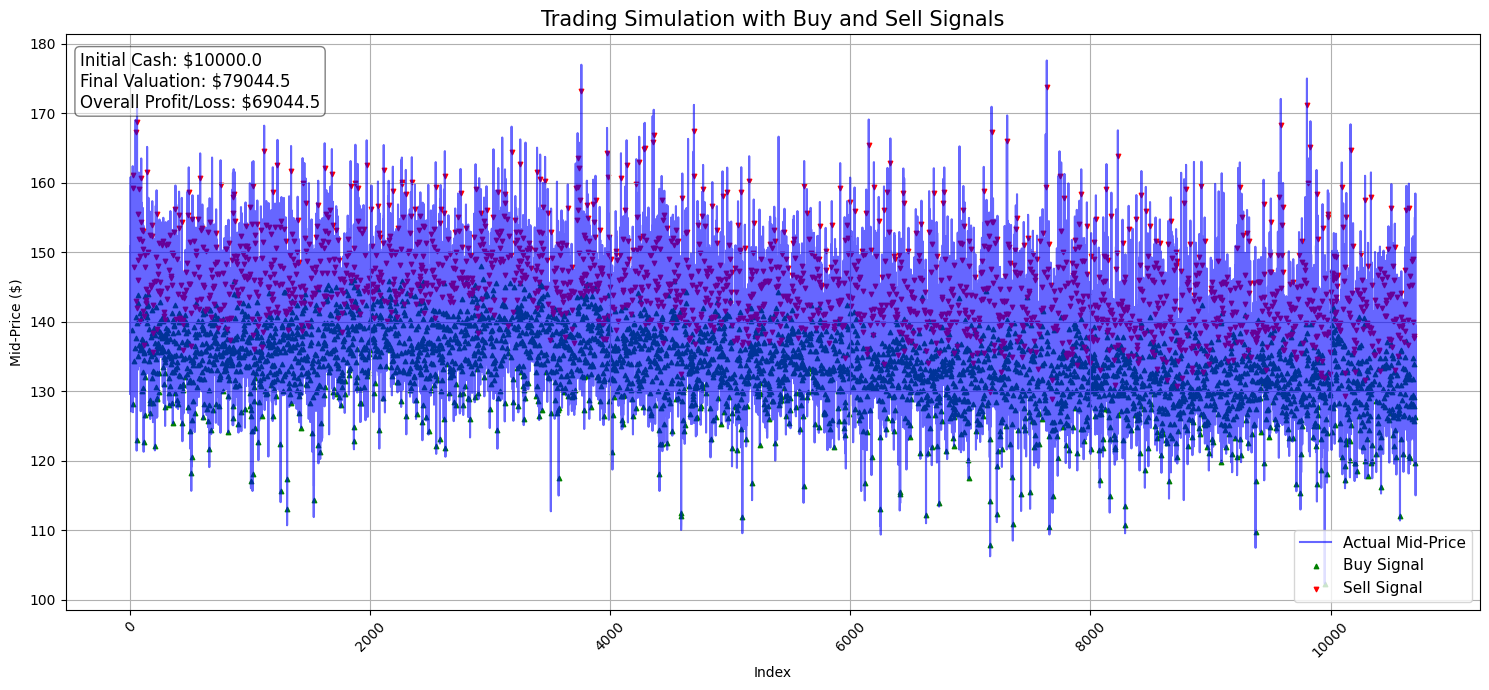

In [127]:
import matplotlib.pyplot as plt
import pandas as pd

# Reset the index of data_test to a simple integer range
data_test.reset_index(drop=False, inplace=True)

# Assuming transactions_test_df already has the transactions with indices that match the new index of data_test
transactions_test_df = pd.DataFrame(transactions_test, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data_test.index, data_test['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)

# Filter transactions by Action to separate buys and sells
buy_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Buy']
sell_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Sell']

# Plotting the buy and sell signals using the index
ax.scatter(buy_signals_test['Time'], buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1.0)
ax.scatter(sell_signals_test['Time'], sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1.0)

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Initial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Text positioning on the axes
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Index')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


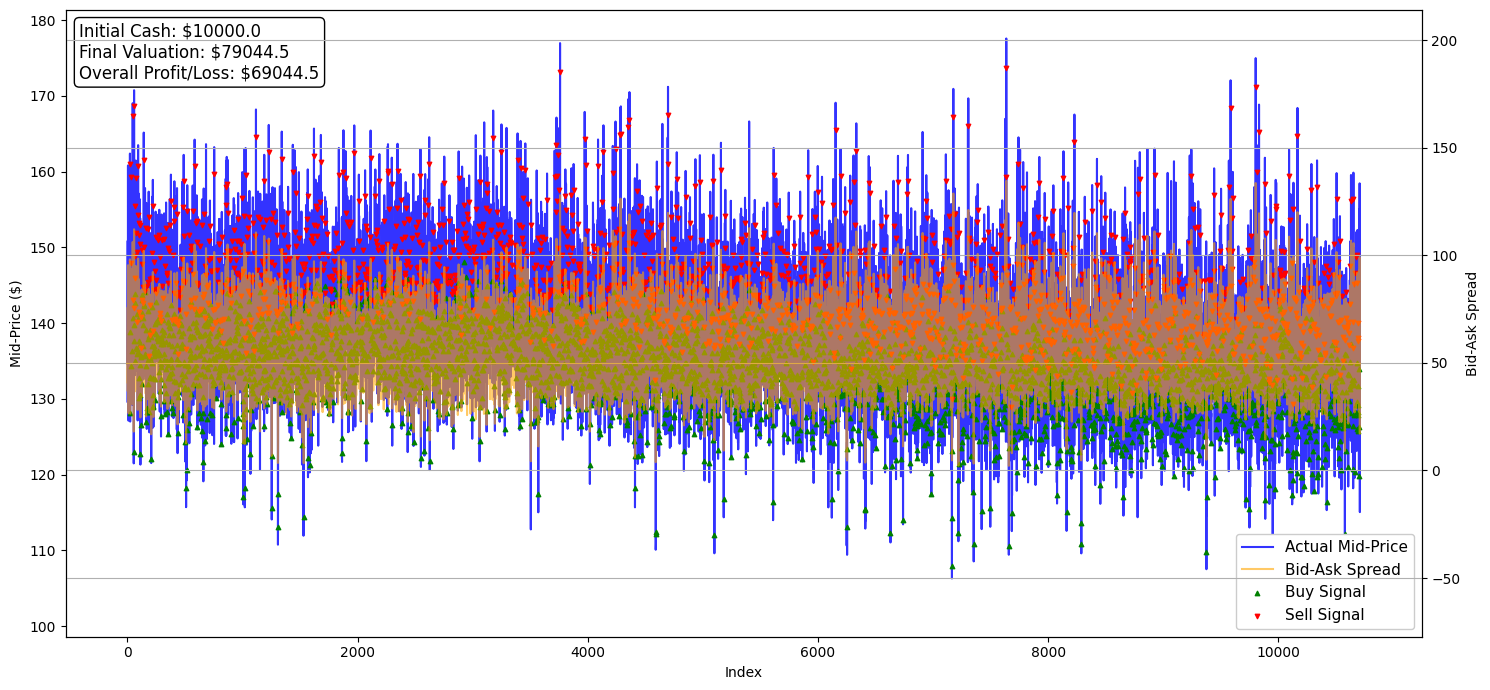

In [129]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Reset the index of data_test to a simple integer range (if needed)
#data_test.reset_index(drop=False, inplace=True)

# Plotting Mid-Price on the primary y-axis
line1, = ax1.plot(data_test.index, data_test['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.8, zorder=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Mid-Price ($)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Bid-Ask Spread
ax2 = ax1.twinx()
line2, = ax2.plot(data_test.index, data_test['Bid_Ask_Spread'], label='Bid-Ask Spread', color='orange', alpha=0.6, zorder=2)
ax2.set_ylabel('Bid-Ask Spread', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the scale of the Bid-Ask Spread axis if needed
min_spread = data_test['Bid_Ask_Spread'].min()
max_spread = data_test['Bid_Ask_Spread'].max()
spread_range = max_spread - min_spread
ax2.set_ylim([min_spread - 0.6 * spread_range, max_spread + 0.6 * spread_range])

# Filter transactions by Action to separate buys and sells
buy_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Buy']
sell_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Sell']

# Plotting the buy and sell signals using the index
buy_scatter = ax1.scatter(buy_signals_test['Time'], buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1, zorder=4)
sell_scatter = ax1.scatter(sell_signals_test['Time'], sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1, zorder=5)

# Ensuring ax2 is visually on top for clarity
ax2.set_zorder(ax1.get_zorder() + 1)
ax1.patch.set_visible(False)  # Make ax1 background transparent

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Initial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=1)
# Text positioning on the axes
ax1.text(0.01, 0.98, text_str, transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=props)

# Legend
legend_handles = [line1, line2, buy_scatter, sell_scatter]
legend = ax1.legend(handles=legend_handles, loc='lower right', fontsize=11)
legend.get_frame().set_alpha(1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
transactions_test.tail(2550)

,Action,Shares,Price,Total Cost,Cash After,Time,Datetime
18820,Hold,500,NaN,0.0,14098.85028,18840,0 2025-01-02 07:30:00 1 2025-01-02...
18821,Hold,500,NaN,0.0,14098.85028,18841,0 2025-01-02 07:30:00 1 2025-01-02...
18822,Hold,500,NaN,0.0,14098.85028,18842,0 2025-01-02 07:30:00 1 2025-01-02...
18823,Hold,500,NaN,0.0,14098.85028,18843,0 2025-01-02 07:30:00 1 2025-01-02...
18824,Hold,500,NaN,0.0,14098.85028,18844,0 2025-01-02 07:30:00 1 2025-01-02...
...,...,...,...,...,...,...,...
21365,Hold,500,NaN,0.0,14098.85028,21385,0 2025-01-02 07:30:00 1 2025-01-02...
21366,Hold,500,NaN,0.0,14098.85028,21386,0 2025-01-02 07:30:00 1 2025-01-02...
21367,Hold,500,NaN,0.0,14098.85028,21387,0 2025-01-02 07:30:00 1 2025-01-02...
21368,Hold,500,NaN,0.0,14098.85028,21388,0 2025-01-02 07:30:00 1 2025-01-02...


Plot final week

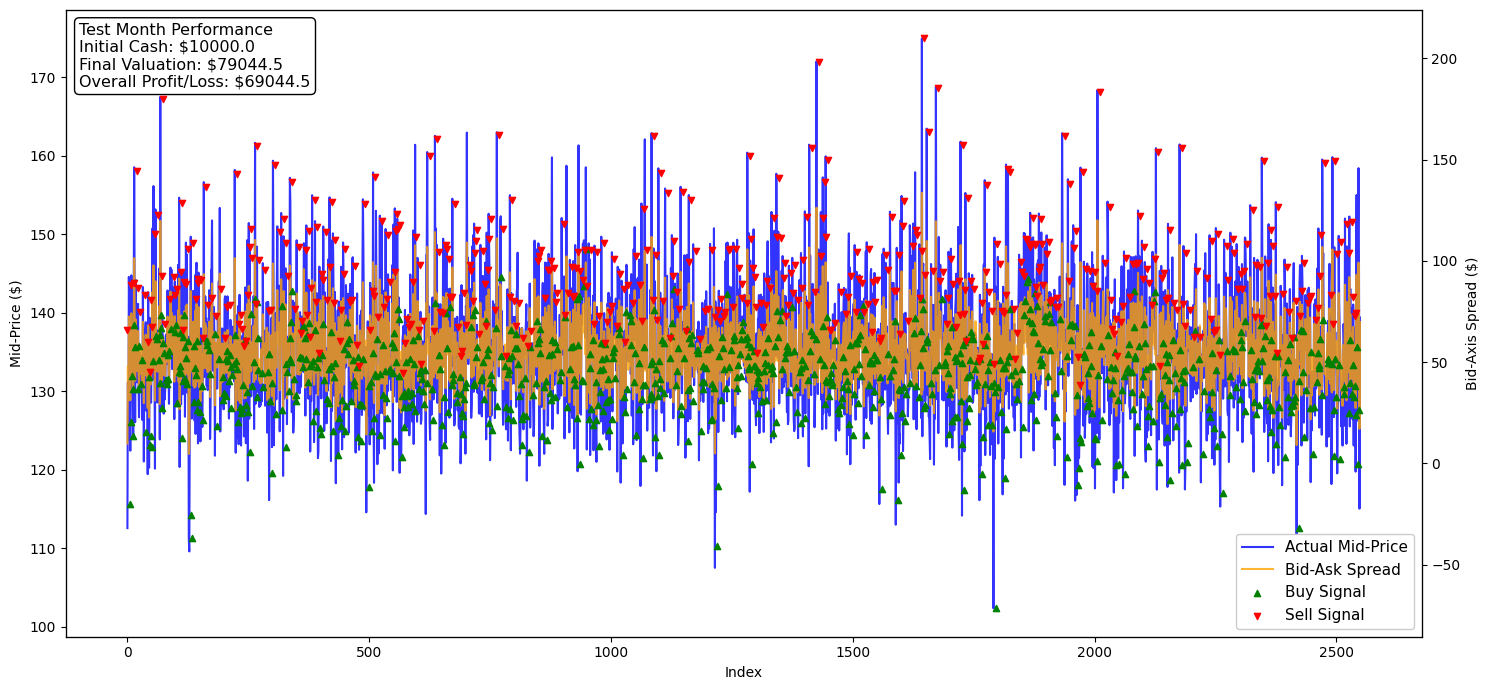

In [159]:
import matplotlib.pyplot as plt

# Assuming data_read and transactions_test_df have been defined and processed elsewhere in your code.

# Preparation of the data
data_week = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()
data_test_lastweek = data_week.tail(2550)
data_test_lastweek.reset_index(drop=True, inplace=True)

transactions_test_lastweek = transactions_test_df.tail(2550)
transactions_test_lastweek.reset_index(drop=True, inplace=True)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Filter transactions by Action to separate buys, sells, and holds
buy_signals_test = transactions_test_lastweek[transactions_test_lastweek['Action'] == 'Buy']
sell_signals_test = transactions_test_lastweek[transactions_test_lastweek['Action'] == 'Sell']

# Plotting the Mid-Price line on ax1
line1, = ax1.plot(data_test_lastweek.index, data_test_lastweek['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.8, zorder=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Mid-Price ($)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Bid-Ask Spread
ax2 = ax1.twinx()
line2, = ax2.plot(data_test_lastweek.index, data_test_lastweek['Bid_Ask_Spread'], label='Bid-Ask Spread', color='orange', alpha=0.8, zorder=2)
ax2.set_ylabel('Bid-Axis Spread ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the scale for the Bid-Ask Spread axis
min_spread = data_test_lastweek['Bid_Ask_Spread'].min()
max_spread = data_test_lastweek['Bid_Ask_Spread'].max()
spread_range = max_spread - min_spread
ax2.set_ylim([min_spread - 0.7 * spread_range, max_spread + 0.7 * spread_range])

# Plotting the phantom axis for markers
ax_markers = ax1.twinx()
ax_markers.set_yticks([])  # Hide y-axis ticks and labels
ax_markers.set_ylabel('')  # Hide y-axis label

# Plotting the buy and sell signals markers on ax_markers
buy_scatter = ax_markers.scatter(buy_signals_test.index, buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=20, alpha=1, zorder=4)
sell_scatter = ax_markers.scatter(sell_signals_test.index, sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=20, alpha=1, zorder=4)

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Test Month Performance\nInitial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=1)
# Text positioning on the axes
ax2.text(0.01, 0.98, text_str, transform=ax1.transAxes, fontsize=11.5, verticalalignment='top', bbox=props)

# Legend
legend_handles = [line1, line2, buy_scatter, sell_scatter]
legend = ax1.legend(handles=legend_handles, loc='lower right', fontsize=11)
legend.get_frame().set_alpha(1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Plot final day

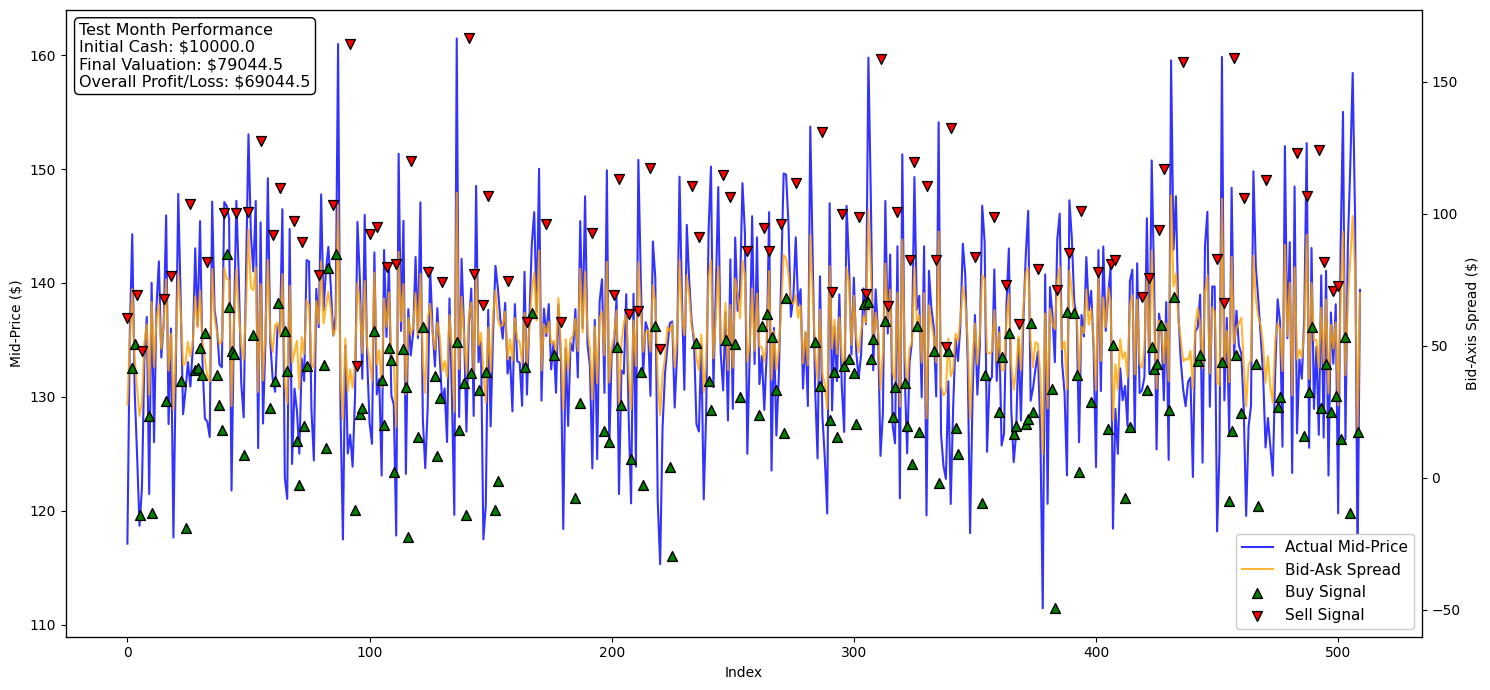

In [163]:
import matplotlib.pyplot as plt

# Assuming data_read and transactions_test_df have been defined and processed elsewhere in your code.

# Preparation of the data
data_week = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()
data_test_lastday = data_week.tail(510)
data_test_lastday.reset_index(drop=True, inplace=True)

transactions_test_lastday = transactions_test_df.tail(510)
transactions_test_lastday.reset_index(drop=True, inplace=True)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Filter transactions by Action to separate buys, sells, and holds
buy_signals_test = transactions_test_lastday[transactions_test_lastday['Action'] == 'Buy']
sell_signals_test = transactions_test_lastday[transactions_test_lastday['Action'] == 'Sell']

# Plotting the Mid-Price line on ax1
line1, = ax1.plot(data_test_lastday.index, data_test_lastday['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.8, zorder=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Mid-Price ($)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Bid-Ask Spread
ax2 = ax1.twinx()
line2, = ax2.plot(data_test_lastday.index, data_test_lastday['Bid_Ask_Spread'], label='Bid-Ask Spread', color='orange', alpha=0.8, zorder=2)
ax2.set_ylabel('Bid-Axis Spread ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the scale for the Bid-Ask Spread axis
min_spread = data_test_lastday['Bid_Ask_Spread'].min()
max_spread = data_test_lastday['Bid_Ask_Spread'].max()
spread_range = max_spread - min_spread
ax2.set_ylim([min_spread - 0.7 * spread_range, max_spread + 0.7 * spread_range])

# Plotting the phantom axis for markers
ax_markers = ax1.twinx()
ax_markers.set_yticks([])  # Hide y-axis ticks and labels
ax_markers.set_ylabel('')  # Hide y-axis label

# Plotting the buy and sell signals markers on ax_markers
buy_scatter = ax_markers.scatter(buy_signals_test.index, buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1, zorder=4, edgecolor='black')
sell_scatter = ax_markers.scatter(sell_signals_test.index, sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1, zorder=4, edgecolor='black')

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Test Month Performance\nInitial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=1)
# Text positioning on the axes
ax2.text(0.01, 0.98, text_str, transform=ax1.transAxes, fontsize=11.5, verticalalignment='top', bbox=props)

# Legend
legend_handles = [line1, line2, buy_scatter, sell_scatter]
legend = ax1.legend(handles=legend_handles, loc='lower right', fontsize=11)
legend.get_frame().set_alpha(1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
transactions_test_lastweek.head(20)
data_test_lastweek.head(20)

,DateTime_Minute,Bid1_Price,Bid1_Volume,Ask1_Price,Ask1_Volume,Bid2_Price,Bid2_Volume,Ask2_Price,Ask2_Volume,Mid-Price,...,Highest_Price,Trade_Volume,Price_Mean,RSI,MACD,MACD_signal,MACD_hist,KDJ_K,KDJ_D,KDJ_J
0,2025-06-24 07:30:00,107.64,1961.0,117.47,1232.0,105.45,3302.0,165.41,1683.0,112.56,...,111.0,76.0,107.97,44.81,-0.499862,-0.344383,-0.155479,64.304352,64.847515,63.218027
1,2025-06-24 07:31:00,107.17,3921.0,155.12,1481.0,101.04,3071.0,221.51,1592.0,131.15,...,111.0,105.0,107.71,50.95,-0.231294,-0.321765,0.090471,70.647346,66.780792,78.380454
2,2025-06-24 07:32:00,108.15,2514.0,139.42,1738.0,105.60,2686.0,187.59,1677.0,123.79,...,111.0,99.0,107.77,54.03,-0.177786,-0.292969,0.115184,71.172305,68.244629,77.027655
3,2025-06-24 07:33:00,108.30,2048.0,180.85,1861.0,106.51,3333.0,264.41,1956.0,144.58,...,111.0,96.0,108.34,48.56,-0.213609,-0.277097,0.063488,69.670425,68.719895,71.571487
4,2025-06-24 07:34:00,108.34,1842.0,172.60,1204.0,105.86,1637.0,217.32,1282.0,140.47,...,111.0,86.0,108.79,49.49,-0.223288,-0.266336,0.043048,69.039543,68.826444,69.465740
5,2025-06-24 07:35:00,108.72,2674.0,146.62,2302.0,105.54,4164.0,208.89,2187.0,127.67,...,111.0,101.0,108.45,50.62,-0.199608,-0.252990,0.053382,69.285621,68.979503,69.897857
6,2025-06-24 07:36:00,106.82,1786.0,138.05,1254.0,103.67,1049.0,194.40,1232.0,122.43,...,111.0,72.0,107.17,54.42,0.175408,-0.167310,0.342718,77.671896,71.876967,89.261752
7,2025-06-24 07:37:00,107.31,3488.0,150.32,2257.0,104.30,3306.0,212.57,1964.0,128.82,...,111.0,115.0,108.02,55.14,0.467224,-0.040403,0.507628,83.262745,75.672227,98.443782
8,2025-06-24 07:38:00,107.71,2602.0,181.85,2032.0,105.58,1665.0,236.43,2125.0,144.78,...,111.0,81.0,107.51,44.61,-0.027418,-0.037806,0.010389,70.323312,73.889255,63.191425
9,2025-06-24 07:39:00,109.22,2476.0,158.04,2073.0,105.96,2467.0,207.52,2080.0,133.63,...,111.0,90.0,109.07,52.08,0.303303,0.030416,0.272888,78.363689,75.380733,84.329602


Output Test Simulation figure

In [ ]:
fig.savefig('Trading Simulation June.png', dpi=600, bbox_inches='tight')

3. Parameter Optimisation Code

Load training data for optimisation

In [ ]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')
# Jan to May (Train)
data = data_read[data_read['DateTime_Minute'] <= '2025-05-31'].copy()
# June (Test)
#data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()

Run parameter optimisation trading simulation 

In [ ]:
def run_trading_simulation(future_buy_increase, future_sell_decrease, bid_ask_spread_threshold):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation
    buy_signals = 0
    sell_signals = 0

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.005
    exchange_fee_per_share = 0.003
    shares_per_transaction = 500

    look_ahead_window = 5 
    look_back_window = 20
  
    for i in range(look_back_window, len(data) - look_ahead_window):
        # Mid_price
        current_mid_price = data.iloc[i]['Mid-Price']
        future_prices = data.iloc[i+1:i+look_ahead_window+1]['Mid-Price']
        future_avg_price = future_prices.mean()

        # Bid_ask_spread      
        bid_ask_spread_threshold = data.iloc[i-look_back_window:i]['Bid_Ask_Spread'].quantile(q_value)
        future_bid_ask = data.iloc[i+1:i+look_ahead_window+1]['Bid_Ask_Spread']
        future_bid_ask_avg = future_bid_ask.mean()
        is_liquid = future_bid_ask_avg <= bid_ask_spread_threshold

        if future_avg_price > current_mid_price * future_buy_increase and is_liquid and cash > 0:
            # Buy condition
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            volume_ratio = (shares_to_buy) / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
            buy_signals += 1

        elif future_avg_price < current_mid_price * future_sell_decrease and is_liquid and shares_owned > 0:
            # Sell condition
            shares_to_sell = min(shares_per_transaction, shares_owned)
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0
            sell_signals += 1

        # Hold condition
        else: 
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Performance Metrics
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna() # daily returns from portfolio values
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data)) - 1
    else:
        # cases where annual return cannot be computed
        annual_return = None
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return final_valuation - initial_cash, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns

# Define parameter ranges
future_buy_increases = [1.01, 1.02, 1.03]
future_sell_decreases = [0.99, 0.98, 0.97]
q_values = [0.8, 0.85, 0.9]

results = []

# nested loops for parameter testing
for future_buy_increase in future_buy_increases:
    for future_sell_decrease in future_sell_decreases:
        for q_value in q_values:
            profit_loss, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns = run_trading_simulation(
                future_buy_increase,
                future_sell_decrease,
                q_value
            )
            results.append((future_buy_increase, future_sell_decrease, q_value, profit_loss, len(transactions), buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio))

# Output results
results_df = pd.DataFrame(results, columns=['Future Buy Increase', 'Future Sell Decrease', 'Quantiles', 'Profit/Loss', 'Number of Transactions', 'Number of Buy Signals', 'Number of Sell Signals', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
print(results_df.head(50))
results_df.to_csv('Trading Simulation Backtest Results.csv')



    Future Buy Increase  Future Sell Decrease  Quantiles   Profit/Loss  \
0                  1.01                  0.99       0.80  65890.707469   
1                  1.01                  0.99       0.85  66002.423742   
2                  1.01                  0.99       0.90  65938.843374   
3                  1.01                  0.98       0.80  65899.712594   
4                  1.01                  0.98       0.85  65912.717361   
5                  1.01                  0.98       0.90  66007.156713   
6                  1.01                  0.97       0.80  65935.801553   
7                  1.01                  0.97       0.85  65981.652105   
8                  1.01                  0.97       0.90  65966.395726   
9                  1.02                  0.99       0.80  66018.841985   
10                 1.02                  0.99       0.85  65986.516443   
11                 1.02                  0.99       0.90  65928.312546   
12                 1.02               

Plot of Daily Returns

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7)) 
plt.plot(daily_returns, marker='o', linestyle='-', markersize=4)
plt.title('Daily Returns Over Time')  
plt.xlabel('Date')
plt.ylabel('Daily Return') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
plt.tight_layout()

plt.show()

NameError: name 'daily_returns' is not defined

<Figure size 1400x700 with 0 Axes>